In [1]:
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from torchsummary import summary

In [11]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [12]:
class LightVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(LightVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d(4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),

            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.shape[0], -1)

        x = self.classifier(x)

        return x

In [13]:
def train_model(model, device, train_loader, val_loader, num_epochs, optimizer, patience):
    start_time = time.time()

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    counter = 0
    best_val_loss = 0

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_correct = 0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)
            loss = F.cross_entropy(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            running_correct += (predicted_labels == targets).sum().item()

            if not batch_idx % 50:
                print(f"Epoch: {epoch+1:02d}/{num_epochs:02d} | Mini-Batch {batch_idx:03d}/{len(train_loader):03d} | Loss: {loss:.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = running_correct / len(train_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()

        with torch.no_grad():
            val_loss, correct_preds, num_examples = 0., 0, 0

            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.to(device)

                outputs = model(features)

                loss = F.cross_entropy(outputs, targets, reduction='sum')

                val_loss += loss

                _, predicted_labels = torch.max(outputs, 1)

                correct_preds += (predicted_labels == targets).sum()

                num_examples += targets.size(0)

            val_loss = val_loss / num_examples

            val_acc = correct_preds.float() / num_examples * 100

            print(f"\nVal Loss: {val_loss:.3f} | Val Accuracy: {val_acc:.3f}\n")

            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if not best_val_loss or val_loss < best_val_loss:
                best_val_loss = val_loss

                counter = 0

            else:
                counter += 1

                if counter == patience:
                    print(f"Early stopping at epoch {epoch + 1}!")

                    break


        print(f"Time elapsed: {((time.time() - start_time) / 60):.2f} min\n\n")

    print(f"Total Training Time: {((time.time() - start_time) / 60):.2f} min\n")


    return train_losses, val_losses, train_accs, val_accs

In [14]:
def model_test(model, device, test_loader):
    model.eval()

    with torch.no_grad():
        correct_preds, num_examples = 0, 0

        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            _, predicted_labels = torch.max(outputs, 1)

            correct_preds += (predicted_labels == targets).sum()

            num_examples += targets.size(0)

        test_acc = correct_preds.float() / num_examples * 100

        print(f"Test accuracy: {test_acc:.2f}%")

In [15]:
def draw_confusion_matrix(model, device, classes, test_loader):
    model.eval()

    preds = []
    truths = []

    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            preds.extend(outputs)

            truths.extend(targets.data.cpu().numpy())

    cf_matrix = confusion_matrix(truths, preds)

    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                         index = [i for i in classes],
                         columns = [i for i in classes])

    plt.figure(figsize = (12,7))

    sn.heatmap(df_cm, annot=True)



In [16]:
def draw_cross_validation(train_losses, val_losses, train_accs, val_accs):
    val_losses_cpu = torch.Tensor(val_losses).cpu()
    val_accs_cpu = torch.Tensor(val_accs).cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses_cpu, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs_cpu, label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [17]:
num_classes = 10
learning_rate = 0.001
num_epochs = 25
batch_size = 64
patience = 5

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified


In [19]:
model = LightVGG().to(device)

summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [20]:
optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accs, val_accs = train_model(model, device, train_loader, val_loader, num_epochs, optimizer, patience)

model_test(model, device, test_loader)

Epoch: 01/25 | Mini-Batch 000/704 | Loss: 2.4892
Epoch: 01/25 | Mini-Batch 050/704 | Loss: 1.7926
Epoch: 01/25 | Mini-Batch 100/704 | Loss: 1.5421
Epoch: 01/25 | Mini-Batch 150/704 | Loss: 1.6282
Epoch: 01/25 | Mini-Batch 200/704 | Loss: 1.6838
Epoch: 01/25 | Mini-Batch 250/704 | Loss: 1.5391
Epoch: 01/25 | Mini-Batch 300/704 | Loss: 1.1866
Epoch: 01/25 | Mini-Batch 350/704 | Loss: 1.1520
Epoch: 01/25 | Mini-Batch 400/704 | Loss: 1.1063
Epoch: 01/25 | Mini-Batch 450/704 | Loss: 1.1547
Epoch: 01/25 | Mini-Batch 500/704 | Loss: 1.3437
Epoch: 01/25 | Mini-Batch 550/704 | Loss: 0.8267
Epoch: 01/25 | Mini-Batch 600/704 | Loss: 1.0345
Epoch: 01/25 | Mini-Batch 650/704 | Loss: 1.0465
Epoch: 01/25 | Mini-Batch 700/704 | Loss: 1.1246

Val Loss: 1.066 | Val Accuracy: 63.040

Time elapsed: 4.64 min


Epoch: 02/25 | Mini-Batch 000/704 | Loss: 1.1493
Epoch: 02/25 | Mini-Batch 050/704 | Loss: 1.1039
Epoch: 02/25 | Mini-Batch 100/704 | Loss: 0.8483
Epoch: 02/25 | Mini-Batch 150/704 | Loss: 0.8573
Epo

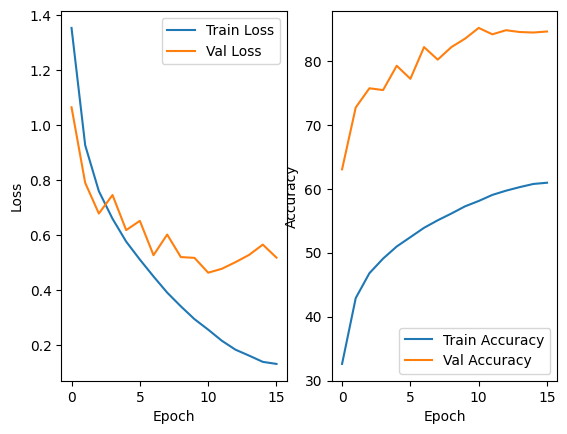

In [21]:
draw_cross_validation(train_losses, val_losses, train_accs, val_accs)

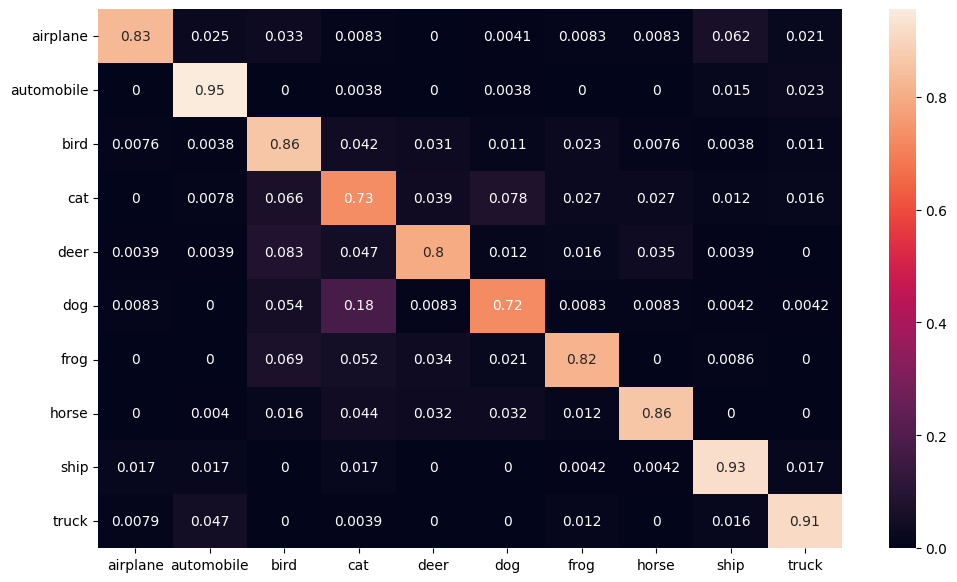

In [22]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

draw_confusion_matrix(model, device, classes, test_loader)

In [ ]:
torch.save(model, "vgg16_cifar10.pt")